In [1]:
import gc
import multiprocessing
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score
# import lightgbm as lgb
# from tqdm import tqdm_notebook

In [2]:
df = pd.read_csv("../curated-data/ModelData.csv")
df.head(5)

,NASA,TA,EXT,AGR,CS,NT,OP,AV,EM,Task,...,BR,NP,SR,AP,AR,DWH,DWR,T,DS,Rank
0,24,38,2,8,10,3,8,16,17,26,...,2,2,1,1,4,2,70,1,1,2
1,17,35,6,9,7,4,8,25,14,31,...,2,2,1,1,5,1,70,1,1,1
2,16,54,3,7,3,9,6,23,24,16,...,1,2,0,2,2,2,60,1,2,0
3,18,28,6,4,10,3,8,13,12,35,...,1,1,1,2,5,1,60,2,1,2
4,15,42,7,8,10,8,10,22,16,30,...,2,2,0,2,4,2,80,2,2,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NASA    360 non-null    int64  
 1   TA      360 non-null    int64  
 2   EXT     360 non-null    int64  
 3   AGR     360 non-null    int64  
 4   CS      360 non-null    int64  
 5   NT      360 non-null    int64  
 6   OP      360 non-null    int64  
 7   AV      360 non-null    int64  
 8   EM      360 non-null    int64  
 9   Task    360 non-null    int64  
 10  H       360 non-null    float64
 11  RS      360 non-null    int64  
 12  WH      360 non-null    int64  
 13  TWR     360 non-null    int64  
 14  BR      360 non-null    int64  
 15  NP      360 non-null    int64  
 16  SR      360 non-null    int64  
 17  AP      360 non-null    int64  
 18  AR      360 non-null    int64  
 19  DWH     360 non-null    int64  
 20  DWR     360 non-null    int64  
 21  T       360 non-null    int64  
 22  DS

<AxesSubplot:>

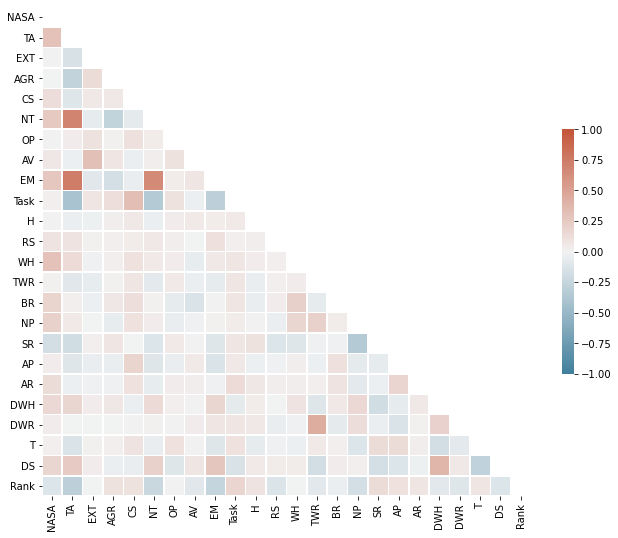

In [4]:
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [5]:
df.columns

Index(['NASA', 'TA', 'EXT', 'AGR', 'CS', 'NT', 'OP', 'AV', 'EM', 'Task', 'H',
       'RS', 'WH', 'TWR', 'BR', 'NP', 'SR', 'AP', 'AR', 'DWH', 'DWR', 'T',
       'DS', 'Rank'],
      dtype='object')

In [6]:
# for col in ['RS', 'WH', 'TWR', 'BR', 'NP', 'SR', 'AP', 'AR', 'DWH', 'DWR', 'T', 'DS', 'Rank']:
#     df[col] = df[col].astype('category')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NASA    360 non-null    int64  
 1   TA      360 non-null    int64  
 2   EXT     360 non-null    int64  
 3   AGR     360 non-null    int64  
 4   CS      360 non-null    int64  
 5   NT      360 non-null    int64  
 6   OP      360 non-null    int64  
 7   AV      360 non-null    int64  
 8   EM      360 non-null    int64  
 9   Task    360 non-null    int64  
 10  H       360 non-null    float64
 11  RS      360 non-null    int64  
 12  WH      360 non-null    int64  
 13  TWR     360 non-null    int64  
 14  BR      360 non-null    int64  
 15  NP      360 non-null    int64  
 16  SR      360 non-null    int64  
 17  AP      360 non-null    int64  
 18  AR      360 non-null    int64  
 19  DWH     360 non-null    int64  
 20  DWR     360 non-null    int64  
 21  T       360 non-null    int64  
 22  DS

In [8]:
corrs = df.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
corrs = corrs[corrs['level_0'] != corrs['level_1']]
corrs.tail(30)

,level_0,level_1,0
522,DS,T,0.276365
523,T,DS,0.276365
524,Task,EM,0.292114
525,EM,Task,0.292114
526,Rank,TA,0.294248
527,TA,Rank,0.294248
528,NASA,TA,0.300856
529,TA,NASA,0.300856
530,WH,NASA,0.301692
531,NASA,WH,0.301692


In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df['SR']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

X_train = strat_train_set.drop('SR', axis=1)
Y_train = strat_train_set['SR'].copy()

X_test = strat_test_set.drop('SR', axis=1)
Y_test = strat_test_set['SR'].copy()

In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288 entries, 307 to 232
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NASA    288 non-null    int64  
 1   TA      288 non-null    int64  
 2   EXT     288 non-null    int64  
 3   AGR     288 non-null    int64  
 4   CS      288 non-null    int64  
 5   NT      288 non-null    int64  
 6   OP      288 non-null    int64  
 7   AV      288 non-null    int64  
 8   EM      288 non-null    int64  
 9   Task    288 non-null    int64  
 10  H       288 non-null    float64
 11  RS      288 non-null    int64  
 12  WH      288 non-null    int64  
 13  TWR     288 non-null    int64  
 14  BR      288 non-null    int64  
 15  NP      288 non-null    int64  
 16  AP      288 non-null    int64  
 17  AR      288 non-null    int64  
 18  DWH     288 non-null    int64  
 19  DWR     288 non-null    int64  
 20  T       288 non-null    int64  
 21  DS      288 non-null    int64  
 22  

In [11]:
Y_train.value_counts()

0    197
1     91
Name: SR, dtype: int64

In [12]:
Y_test.value_counts()

0    49
1    23
Name: SR, dtype: int64

In [13]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72 entries, 162 to 153
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NASA    72 non-null     int64  
 1   TA      72 non-null     int64  
 2   EXT     72 non-null     int64  
 3   AGR     72 non-null     int64  
 4   CS      72 non-null     int64  
 5   NT      72 non-null     int64  
 6   OP      72 non-null     int64  
 7   AV      72 non-null     int64  
 8   EM      72 non-null     int64  
 9   Task    72 non-null     int64  
 10  H       72 non-null     float64
 11  RS      72 non-null     int64  
 12  WH      72 non-null     int64  
 13  TWR     72 non-null     int64  
 14  BR      72 non-null     int64  
 15  NP      72 non-null     int64  
 16  AP      72 non-null     int64  
 17  AR      72 non-null     int64  
 18  DWH     72 non-null     int64  
 19  DWR     72 non-null     int64  
 20  T       72 non-null     int64  
 21  DS      72 non-null     int64  
 22  R

Distributions of all columns


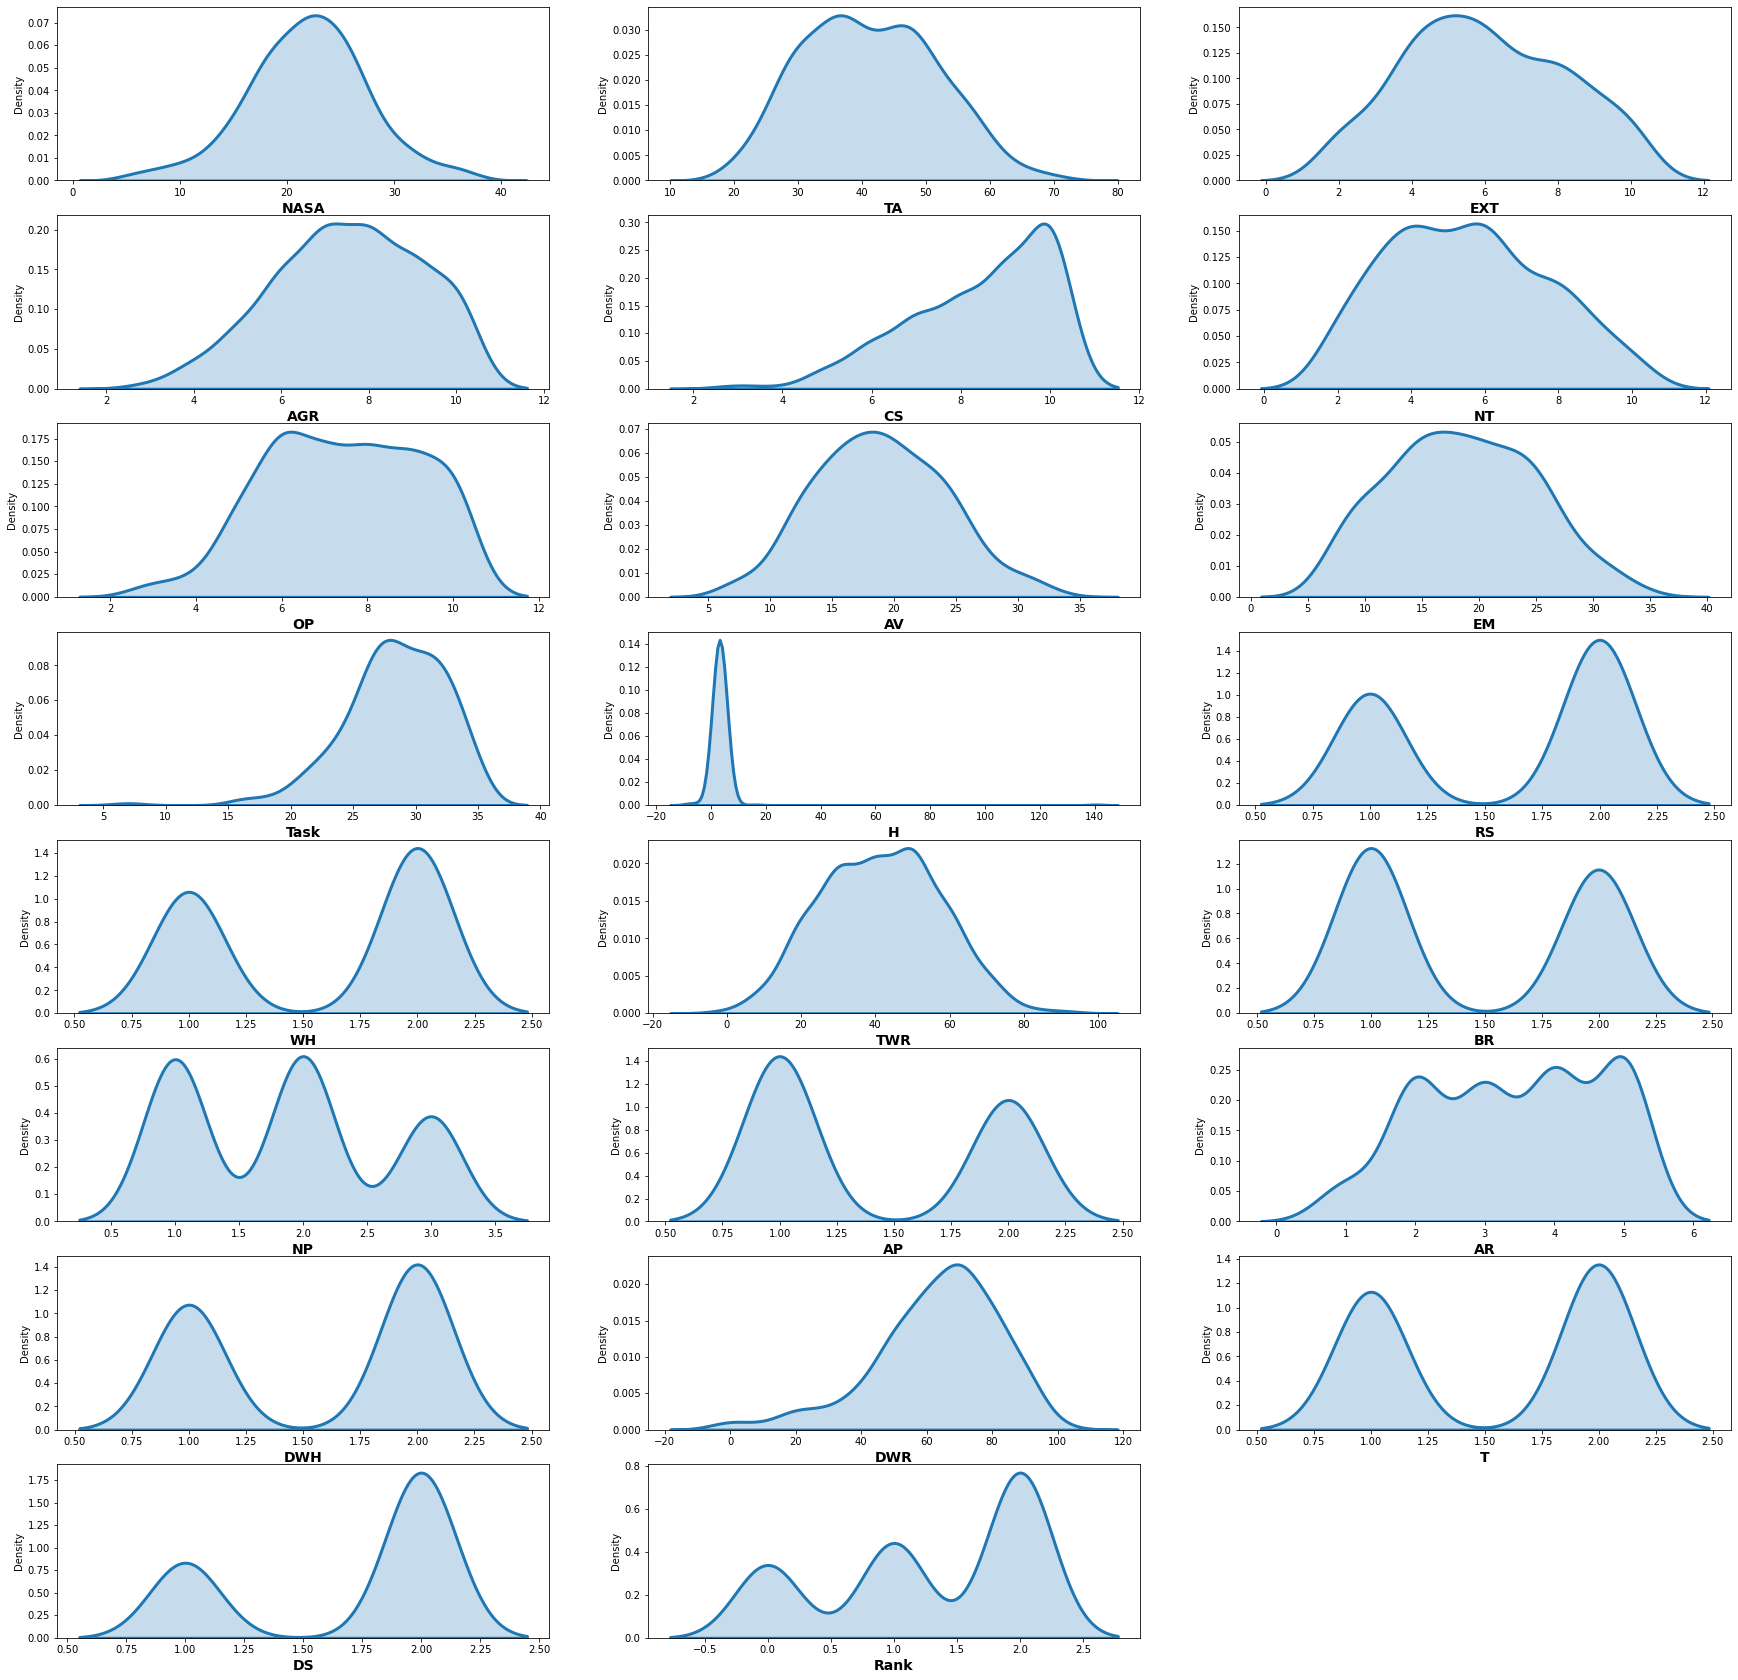

In [14]:
print('Distributions of all columns')
plt.figure(figsize=(30, 30))
for i, col in enumerate(list(X_train.columns)[0:23]):
    plt.subplot(8, 3, i + 1)
    sns.distplot(X_train[col], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3})
    plt.xlabel(X_train.columns[i], fontsize=14, fontweight='bold')

In [15]:
from scipy.stats import boxcox
X_train['CS'], lmbda = boxcox(X_train['CS'], lmbda=None)
X_train['OP'], lmbda = boxcox(X_train['OP'], lmbda=None)
X_train['Task'], lmbda = boxcox(X_train['Task'], lmbda=None)

# X_train['CS'] = np.log(X_train['CS'])

In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288 entries, 307 to 232
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NASA    288 non-null    int64  
 1   TA      288 non-null    int64  
 2   EXT     288 non-null    int64  
 3   AGR     288 non-null    int64  
 4   CS      288 non-null    float64
 5   NT      288 non-null    int64  
 6   OP      288 non-null    float64
 7   AV      288 non-null    int64  
 8   EM      288 non-null    int64  
 9   Task    288 non-null    float64
 10  H       288 non-null    float64
 11  RS      288 non-null    int64  
 12  WH      288 non-null    int64  
 13  TWR     288 non-null    int64  
 14  BR      288 non-null    int64  
 15  NP      288 non-null    int64  
 16  AP      288 non-null    int64  
 17  AR      288 non-null    int64  
 18  DWH     288 non-null    int64  
 19  DWR     288 non-null    int64  
 20  T       288 non-null    int64  
 21  DS      288 non-null    int64  
 22  

Distributions of all columns


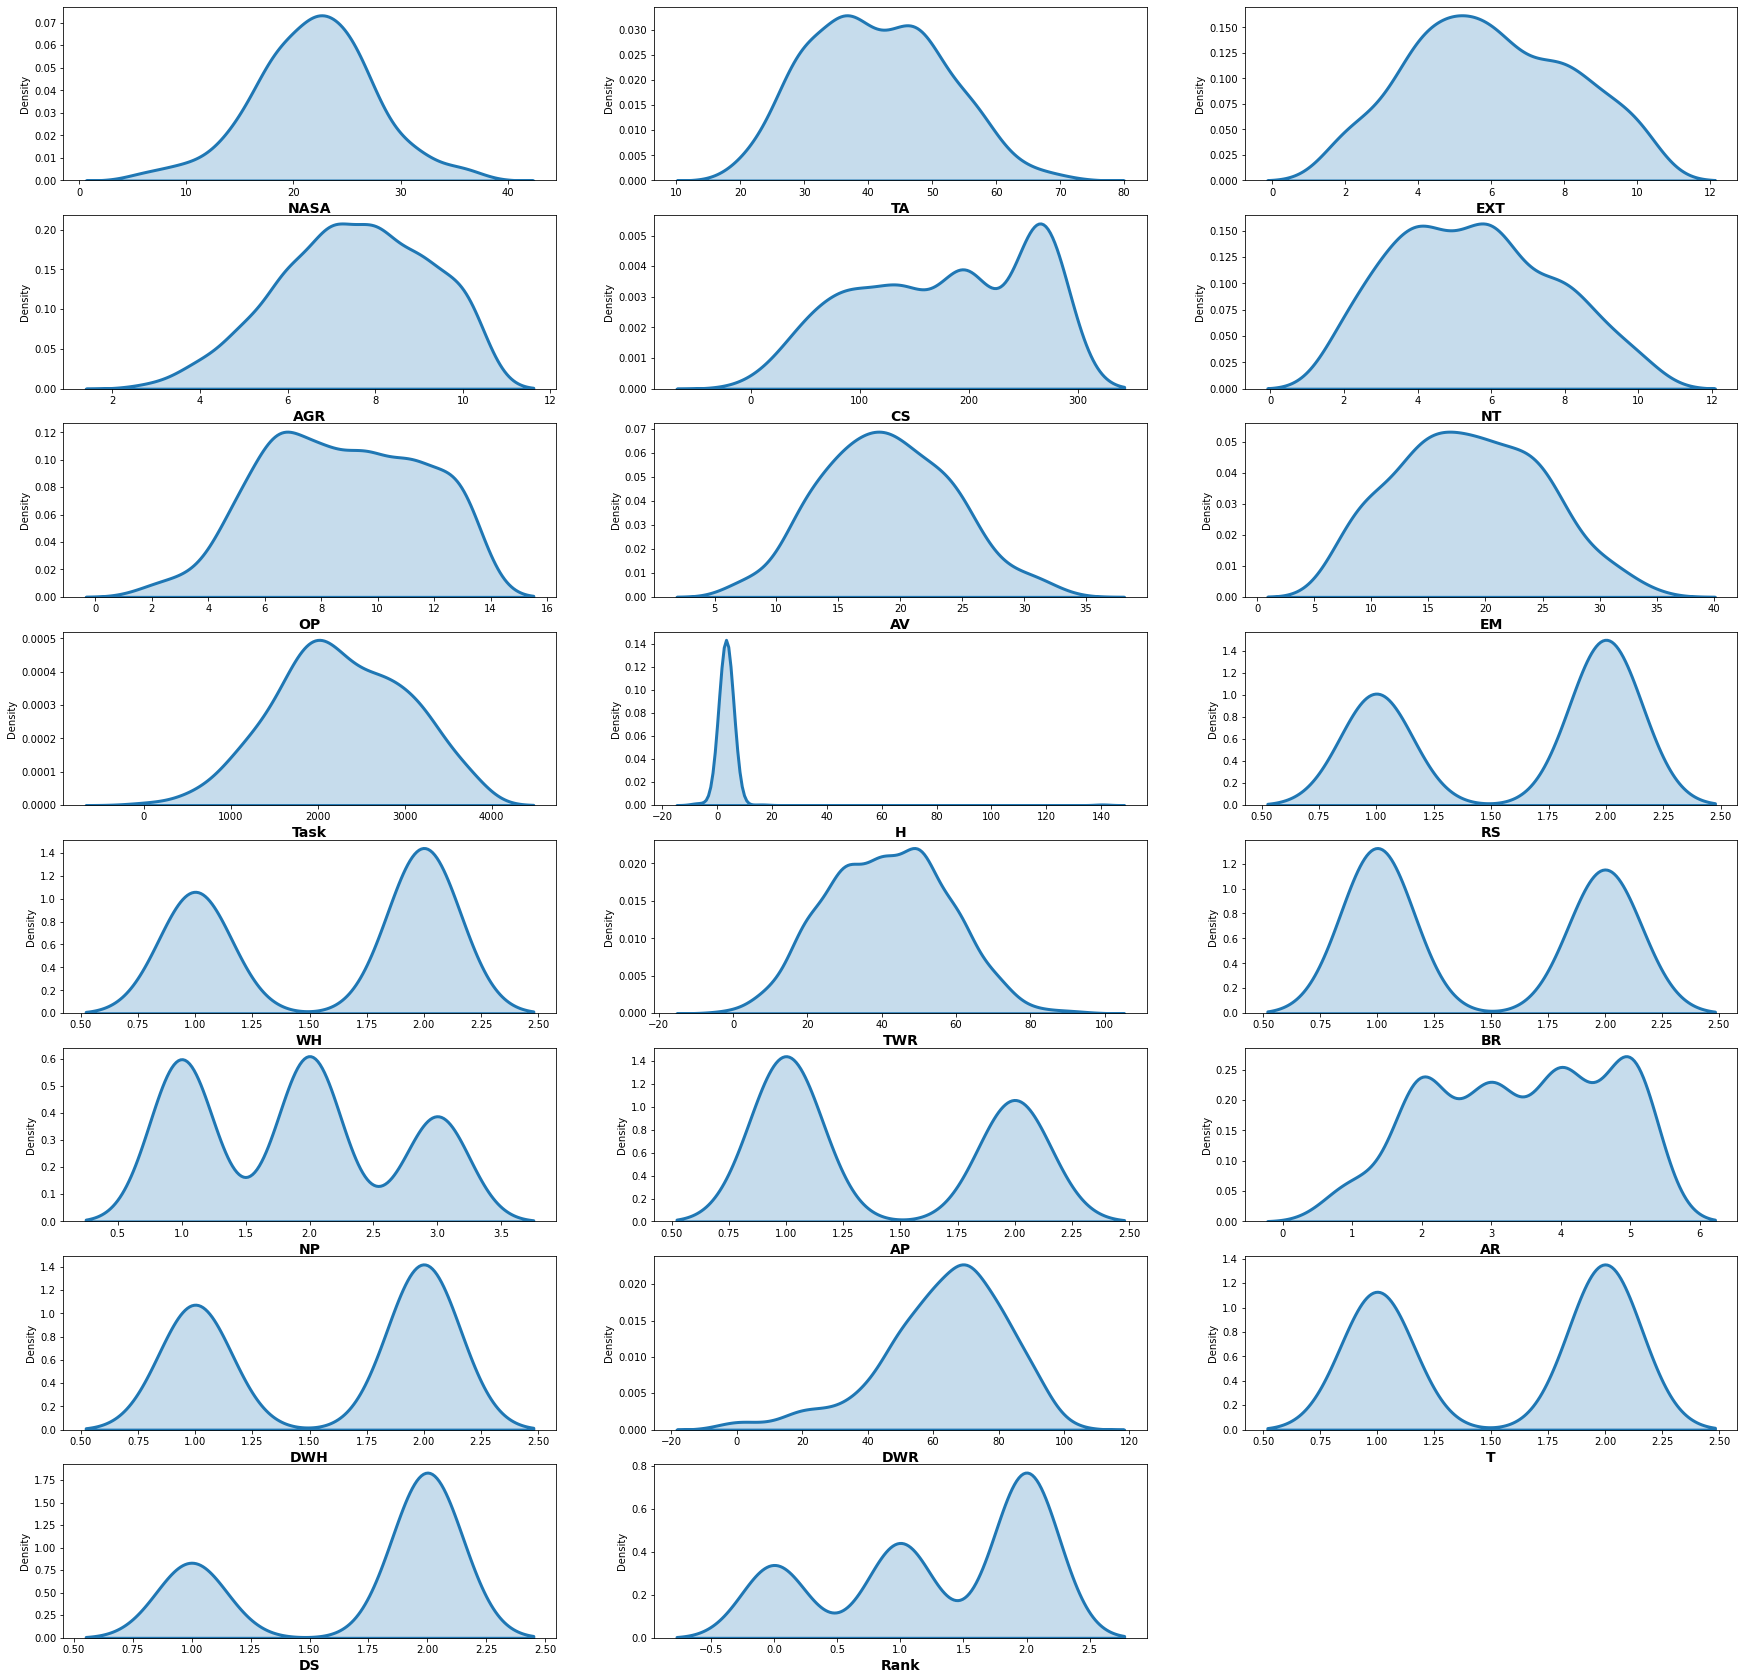

In [17]:
print('Distributions of all columns')
plt.figure(figsize=(30, 30))
for i, col in enumerate(list(X_train.columns)[0:23]):
    plt.subplot(8, 3, i + 1)
    sns.distplot(X_train[col], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3})
    plt.xlabel(X_train.columns[i], fontsize=14, fontweight='bold')

Distributions of all columns


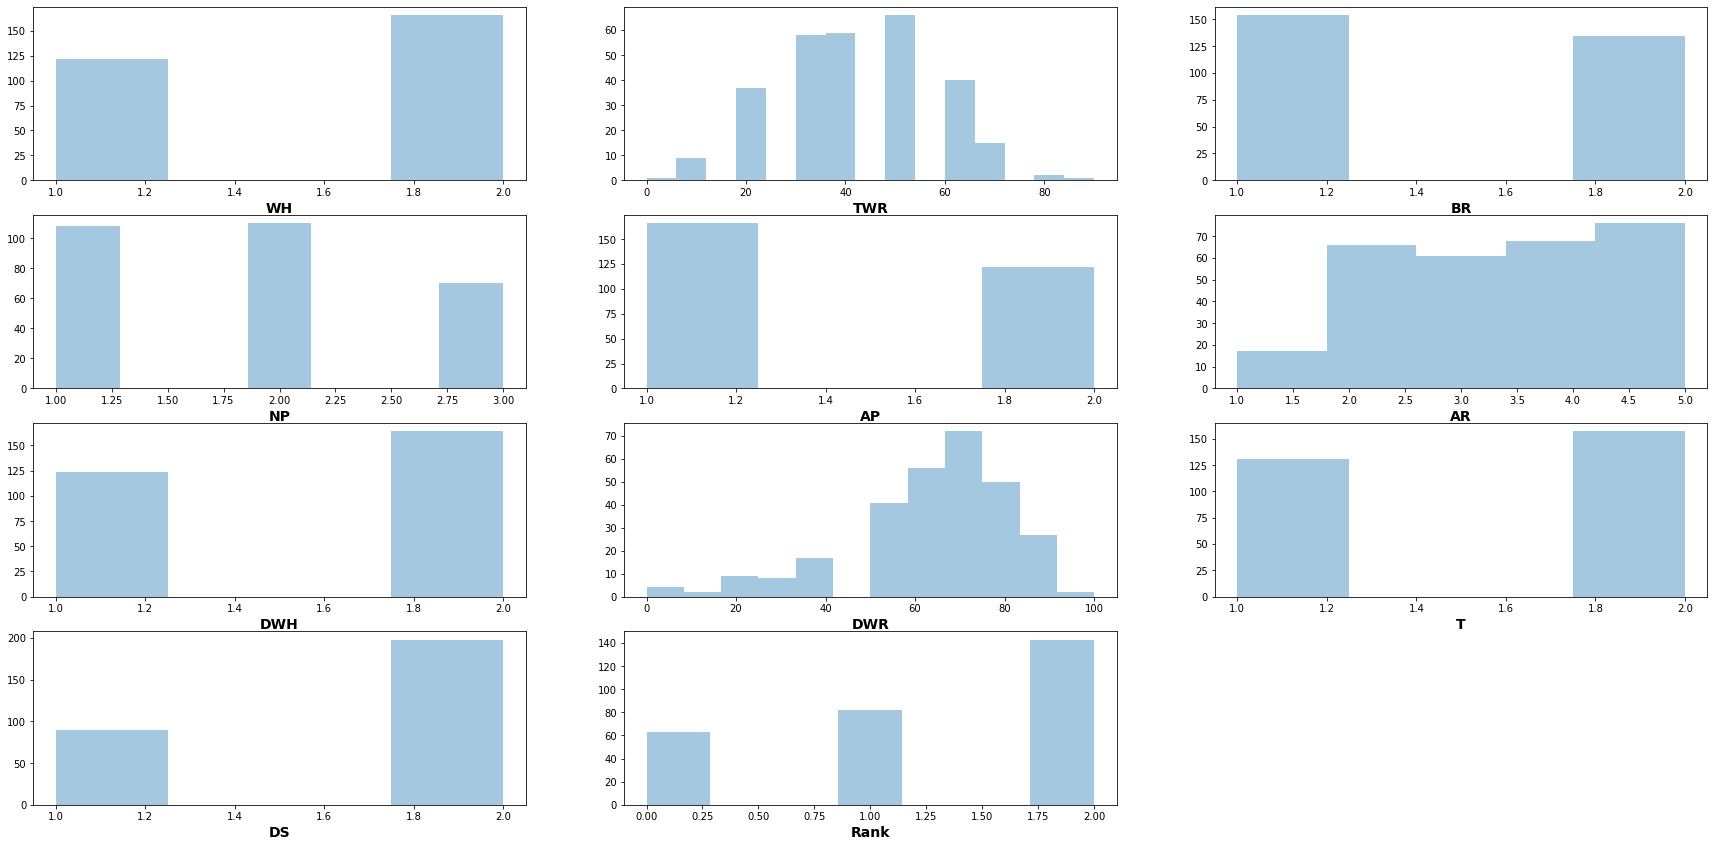

In [18]:
print('Distributions of all columns')
plt.figure(figsize=(30, 30))
for i, col in enumerate((X_train.columns)[0:24]):
# for i in range(12:24):
#     print(i)
    if i > 11:
        plt.subplot(8, 3, i + 1)
        sns.distplot(X_train[col],  hist = True, kde = False)
        plt.xlabel(X_train.columns[i], fontsize=14, fontweight='bold')

In [19]:
%%time
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, Y_train)

Wall time: 168 ms


RandomForestClassifier()

In [20]:
df_feature_importance = pd.DataFrame(rf.feature_importances_, index=X_train.columns, columns=['feature importance']).sort_values('feature importance', ascending=False)

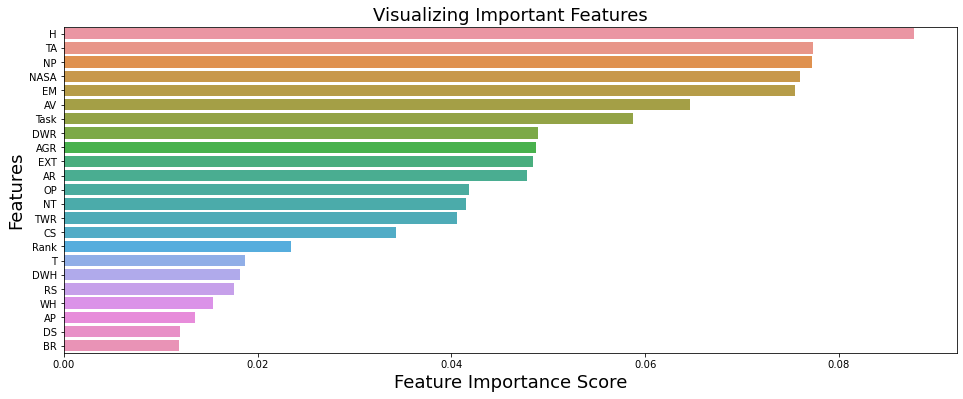

In [21]:

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df_feature_importance = pd.DataFrame(rf.feature_importances_, index=X_train.columns, columns=['feature importance']).sort_values('feature importance', ascending=False)
feature_imp = pd.Series(rf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
# Creating a bar plot
plt.figure(figsize=(16, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score', fontsize=18)
plt.ylabel('Features', fontsize=18)
plt.title("Visualizing Important Features", fontsize=18)
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)
# plt.legend()
plt.show()

In [22]:
y_pred = rf.predict(X_test)
y_score = rf.predict_proba(X_test)

In [23]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)

In [24]:
# result_df = X_test
# result_df['actual'] = Y_test
# result_df['prediction'] = y_pred
            
# result_df.to_csv('modeling-result/result_df.csv', index=False)

## RandomForestClassifier

In [25]:
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as prfs, accuracy_score

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred))
print("Precision: ", metrics.precision_score(Y_test, y_pred))
print("Recall: ", metrics.recall_score(Y_test, y_pred))
print("F1: ", metrics.f1_score(Y_test, y_pred))
print("Auc Score: ", roc_auc_score(Y_test, y_score[:,1]))

Accuracy: 0.75
Precision:  0.7777777777777778
Recall:  0.30434782608695654
F1:  0.43750000000000006
Auc Score:  0.6712511091393079


In [26]:
!pip install lightgbm

## LGBMClassifier

In [27]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier()

# model = lgbm.train(params, X_train_Std)
clf = lgbm.fit(X_train, Y_train)

y_pred = clf.predict(X_test)
# y_score = clf.predict_proba(X_test)

In [28]:
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as prfs, accuracy_score

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred))
print("Precision: ", metrics.precision_score(Y_test, y_pred))
print("Recall: ", metrics.recall_score(Y_test, y_pred))
print("F1: ", metrics.f1_score(Y_test, y_pred))
print("Auc Score: ", roc_auc_score(Y_test, y_score[:,1]))

Accuracy: 0.7361111111111112
Precision:  1.0
Recall:  0.17391304347826086
F1:  0.29629629629629634
Auc Score:  0.6712511091393079


In [29]:
pd.DataFrame(confusion_matrix(Y_test, y_pred))

,0,1
0,49,0
1,19,4


In [30]:
!pip install xgboost

## XGBClassifier

In [31]:
import xgboost as xgb

lrM = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=12,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    missing=-999,
    random_state=2019
)

lrModel = lrM.fit(X_train, Y_train)

C:\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:19:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [32]:
y_pred = lrModel.predict(X_test)
y_score = lrModel.predict_proba(X_test)

In [33]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred))
print("Precision: ", metrics.precision_score(Y_test, y_pred))
print("Recall: ", metrics.recall_score(Y_test, y_pred))
print("F1: ", metrics.f1_score(Y_test, y_pred))
print("Auc Score: ", roc_auc_score(Y_test, y_score[:,1]))

Accuracy: 0.7222222222222222
Precision:  0.8
Recall:  0.17391304347826086
F1:  0.2857142857142857
Auc Score:  0.7338065661047027


In [34]:
pd.DataFrame(confusion_matrix(Y_test, y_pred))

,0,1
0,48,1
1,19,4
